# 3rd Level Model Structure: Everything (Linking Stages)

In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [1]:
from pyomo import environ as pe
from modules.global_set import m

from modules.reactive_stage import reactive_stage_rule
from modules.condenser_stage2 import condenser_stage_rule

model = pe.ConcreteModel()

# Global Set

In [2]:
model.TRAY = pe.RangeSet(1,1)

# Construct Reactive Stages

In [3]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [4]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [5]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [6]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [7]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [8]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

# Fixing Redundent Stream Variables

In [9]:
# condenser
model.condenser.VLE_block.n_ave.fix(30)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [10]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

In [11]:
u.check_DOF(pe,model)

Active Constraints:	 1840
Active Variables:	 2023
Fixed Variables:	 169
DOF:			 14


# Load Operating Parameters

In [12]:
# condenser
model.condenser.P.fix(19)
#model.condenser.T.fix(30+273.15)
model.condenser.T.setub(30+273.15)
model.condenser.L['out'].setub(6)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(2000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(30)
    
    model.reactive[j].F.fix(2)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(0.4)
    model.reactive[j].z['H2'].fix(0.6)
    model.reactive[j].z['C30H62'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    #model.reactive[j].Q_main.fix(0)

In [13]:
u.check_DOF(pe,model)

Active Constraints:	 1840
Active Variables:	 2023
Fixed Variables:	 180
DOF:			 3


In [14]:
model.obj = pe.Objective(expr = model.condenser.L['P'] ,sense=pe.maximize)

In [15]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['constr_viol_tol'] = 1e-7
opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

opt.options['warm_start_init_point'] = 'yes'
# opt.options['warm_start_bound_push'] = 1e-6
# opt.options['warm_start_mult_bound_push'] = 1e-6
# opt.options['mu_init'] = 1e-6

In [16]:
u.add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [17]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
acceptable_constr_viol_tol=1e-07
max_iter=7000
warm_start_init_point=yes


List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-07                 yes
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes
                   warm_start_init_point = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running wi

  73 -3.7304908e-02 1.12e+02 4.50e+00  -1.0 1.20e+03    -  1.10e-02 3.82e-03h  1
  74 -3.7275435e-02 1.12e+02 1.01e+03  -1.0 1.18e+03    -  4.61e-03 4.26e-05h  1
  75 -3.0717677e-02 1.10e+02 6.22e+02  -1.0 9.84e+02    -  2.81e-04 1.92e-02h  1
  76 -2.2795917e-02 1.08e+02 1.46e+03  -1.0 1.02e+03    -  5.16e-02 2.11e-02h  1
  77 -1.3311838e-02 1.05e+02 1.37e+05  -1.0 1.06e+03    -  3.45e-03 2.33e-02h  1
  78 -1.7822907e-03 1.02e+02 8.28e+06  -1.0 1.09e+03    -  5.86e-02 2.60e-02h  1
  79 -1.7813007e-05 1.02e+02 8.07e+06  -1.0 1.14e+03    -  2.22e-02 3.66e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.3350471e-05 1.01e+02 8.10e+06  -1.0 9.69e+02    -  3.44e-04 1.19e-02h  1
  81 -2.2406426e-05 1.01e+02 8.04e+06  -1.0 1.03e+03    -  6.08e-03 1.34e-04h  1
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  82 -2.1718421e-05 9.93e+01 8.08e+06  -1.0 8.38e+02    -  2.75e-04 1.51e-02h  2
Error in an AMPL evaluation. R

 127 -7.3019427e-02 7.82e+00 4.15e+06  -1.0 1.41e+02  -1.2 9.27e-01 9.90e-01h  1
 128 -7.4116436e-02 7.86e-01 1.00e+06  -1.0 5.41e+01  -1.7 5.66e-01 9.77e-01h  1
 129 -7.3889649e-02 1.05e-01 4.08e+06  -1.0 1.64e+01  -2.2 3.29e-01 8.16e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 -7.4058342e-02 1.99e-02 3.21e+05  -1.0 4.74e+00  -2.6 1.00e+00 9.34e-01h  1
 131 -7.4030093e-02 1.94e-02 4.37e+06  -1.0 4.06e+01    -  7.44e-01 5.92e-02h  5
 132 -7.4025221e-02 2.37e-02 4.84e+06  -1.0 8.86e+01    -  2.80e-01 3.85e-02f  3
 133 -7.3972877e-02 2.35e-02 6.66e+06  -1.0 1.66e+01    -  1.00e+00 5.15e-02h  4
 134 -7.3417531e-02 5.61e-03 1.96e+06  -1.0 1.72e+01    -  1.00e+00 7.70e-01H  1
 135 -7.3104663e-02 2.17e-02 1.28e+07  -1.0 7.02e+00    -  1.00e+00 3.25e-01f  2
 136 -7.2597785e-02 1.25e-02 1.87e+06  -1.0 1.38e+01    -  1.00e+00 7.97e-01H  1
 137 -7.2624177e-02 1.58e-03 1.37e+05  -1.0 5.55e+00    -  1.00e+00 1.00e+00f  1
 138 -7.2626046e-02 5.03e-06

In [18]:
# u.load_all(model,results,'json/3_stage_sandwich_remove_water')

In [19]:
model.ipopt_zL_in.update(model.ipopt_zL_out)
model.ipopt_zU_in.update(model.ipopt_zU_out)

In [20]:
u.beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               20.00 	        74.9662631128 	         0.4434110857 	         0.1231384545
              258.65 	       -86.5248181986 	         1.0411959748 	         0.0000000000
----------------------------------------------------------------------------------------------------
Top Product
V	 0.4434110856899567
L	 0.08267095706492773
W	 0.39197547752160244
----------------------------------------------------------------------------------------------------
Bottom Product L
0.0
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		27.641%		0.587%		 H2       	11.887%		0.635%
CO 		6.459%		0.283%		 CO       	2.807%		0.180%
CO2 		39.492%		14.729%		 CO2      	19.730%		2.697%
H2O 		1.031%		0.000%		 H2O      	38.086%		13.417%
C2H4 		5.098%		3.454%		 C2

In [21]:
u.save_all(model,results,'json/2_stage_sandwich_VLLE')

Valar Morghulis
Entire Solution (include dual) Saved
----------------------------------------------------------------------------------------------------
dict_items([('reactive[1].Q_main', {'Value': -86.52481819857171}), ('reactive[1].x_[in,H2]', {'Value': 0.005871583271700613, 'ipopt_zU_out': 2.5207040582543756e-09, 'ipopt_zL_out': -4.2678425492409266e-07}), ('reactive[1].x_[in,CO]', {'Value': 0.00283465138207058, 'ipopt_zU_out': 2.5130270902643893e-09, 'ipopt_zL_out': -8.8402218886886e-07}), ('reactive[1].x_[in,CO2]', {'Value': 0.14728900307985662, 'ipopt_zU_out': 2.938748930579643e-09, 'ipopt_zL_out': -1.7013513141821515e-08}), ('reactive[1].x_[in,H2O]', {'Value': 3.320960058194936e-07, 'ipopt_zU_out': 2.5059043668218493e-09, 'ipopt_zL_out': -0.0073251470845944276}), ('reactive[1].x_[in,C2H4]', {'Value': 0.03453521659384617, 'ipopt_zU_out': 2.5955411080700827e-09, 'ipopt_zL_out': -7.256079681048302e-08}), ('reactive[1].x_[in,C3H6]', {'Value': 0.10415460371398273, 'ipopt_zU_out': 2.7

### As you can see, because Q is left unfixed, certain energy constraints has 0 multiplier, not active

In [22]:
for i in model.dual:
    if abs(model.dual[i]) == 0:
        print('{:40s}'.format(str(i)),'\t\t',model.dual[i])

reactive[1].heat_balance_main_con        		 0.0
Lh_condenser_con                         		 0.0
reactive[1].energy_block.dH_F_con[C30H62] 		 0.0
reactive[1].energy_block.dH_F_con[CO]    		 0.0
reactive[1].energy_block.dH_F_con[H2]    		 0.0
reactive[1].energy_block.H_F_con         		 0.0
condenser.energy_block.dH_F_con[C30H62]  		 0.0
condenser.energy_block.dH_F_con[CO]      		 0.0
condenser.energy_block.dH_F_con[H2]      		 0.0
condenser.energy_block.H_F_con           		 0.0


# Iterative Data Analysis

In [23]:
import numpy as np
from matplotlib import pyplot as plt

In [24]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = 1 ,sense=pe.maximize)
model.condenser.T.fixed = True

In [25]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
acceptable_constr_viol_tol=1e-07
max_iter=7000
warm_start_init_point=yes


List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-07                 yes
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes
                   warm_start_init_point = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running wi

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  35 -1.0000000e+00 3.82e+01 5.96e+15  -1.0 5.63e+01    -  9.91e-01 4.20e-01h  2
  36 -1.0000000e+00 5.14e+00 1.13e+16  -1.0 4.31e+01    -  9.91e-01 8.65e-01h  1
  37 -1.0000000e+00 1.70e+00 3.35e+15  -1.0 6.30e+01    -  8.11e-01 6.70e-01h  1
  38 -1.0000000e+00 8.53e-01 1.61e+15  -1.0 4.00e+01    -  9.75e-01 4.97e-01h  1
  39 -1.0000000e+00 2.91e-01 5.54e+14  -1.0 1.52e+01    -  9.46e-01 6.59e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.0000000e+00 8.01e-03 1.72e+13  -1.0 8.28e+00    -  9.87e-01 9.72e-01h  1
  41 -1.0000000e+00 7.89e-03 1.69e+13  -1.0 1.09e+02    -  5.40e-01 1.56e-02h  7
  42 -1.0000000e+00 7.76e-03 1.67e+13  -1.0 1.09e+02    -  9.91e-01 1.56e-02h  7
  43 -1.0000000e+00 7.64e-03 1.64e+13  -1.0 1.09e+02    -  3.23e-01 1.56e-02h  7
  44 -1.0000000e+00 7.52e-03 1.62e+13  -1.0 1.09e+02    -  1.00e+00 1.56e-02h  7
  45 -1.0000000e+00 7.40e-03 1

In [31]:
u.update_dual(pe,model)

In [28]:
Trange = np.linspace(model.reactive[1].T.value,201+273.15,50)

In [36]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []

for i in model.reactive[1].r_total_comp:
    rf_data['r'][i] = []

for t in Trange:
    model.reactive[1].T.fix(t)
    results = opt.solve(model,tee=False)
    u.update_dual(pe,model)
    print('Solved, Solution T = {} K'.format(model.reactive[1].T.value))
    rf_data['T'].append(model.reactive[1].T.value)
    rf_data['Q'].append(model.reactive[1].Q_main.value)
    rf_data['V'].append(model.condenser.V['out'].value)
    rf_data['L'].append(model.condenser.L['P'].value)    

    for i in model.reactive[1].r_total_comp:
        rf_data['r'][i].append(model.reactive[1].r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.reactive[1].y['H2O'].value)
    rf_data['y_CO'].append(model.reactive[1].y['CO'].value)
    rf_data['y_H2'].append(model.reactive[1].y['H2'].value)
    rf_data['y_CO2'].append(model.reactive[1].y['CO2'].value)
    rf_data['r_WGS'].append(model.reactive[1].kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.reactive[1].kinetics_block.r_FT_total.value)

Solved, Solution T = 527.4779285461087 K
Solved, Solution T = 526.3896034737392 K
Solved, Solution T = 525.3012784013696 K
Solved, Solution T = 524.212953329 K
Solved, Solution T = 523.1246282566304 K
Solved, Solution T = 522.0363031842609 K
Solved, Solution T = 520.9479781118913 K
Solved, Solution T = 519.8596530395217 K
Solved, Solution T = 518.7713279671522 K
Solved, Solution T = 517.6830028947826 K
Solved, Solution T = 516.594677822413 K
Solved, Solution T = 515.5063527500434 K
Solved, Solution T = 514.418027677674 K
Solved, Solution T = 513.3297026053044 K
Solved, Solution T = 512.2413775329348 K
Solved, Solution T = 511.1530524605652 K
Solved, Solution T = 510.06472738819565 K
Solved, Solution T = 508.9764023158261 K
Solved, Solution T = 507.88807724345656 K
Solved, Solution T = 506.799752171087 K
Solved, Solution T = 505.7114270987174 K
Solved, Solution T = 504.62310202634785 K
Solved, Solution T = 503.5347769539783 K
Solved, Solution T = 502.4464518816087 K
Solved, Solution T =

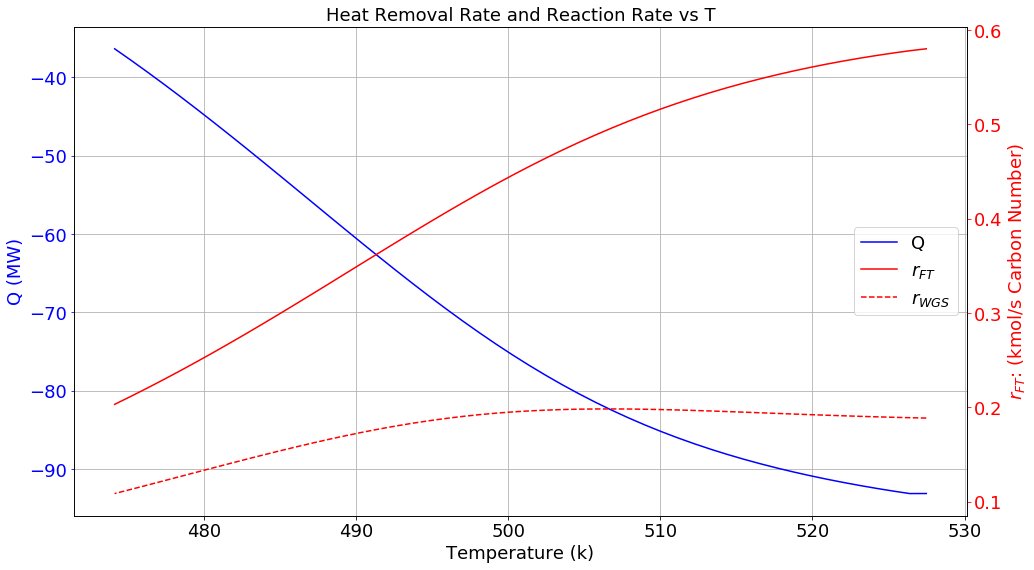

In [37]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3,['Q','$r_{FT}$','$r_{WGS}$'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

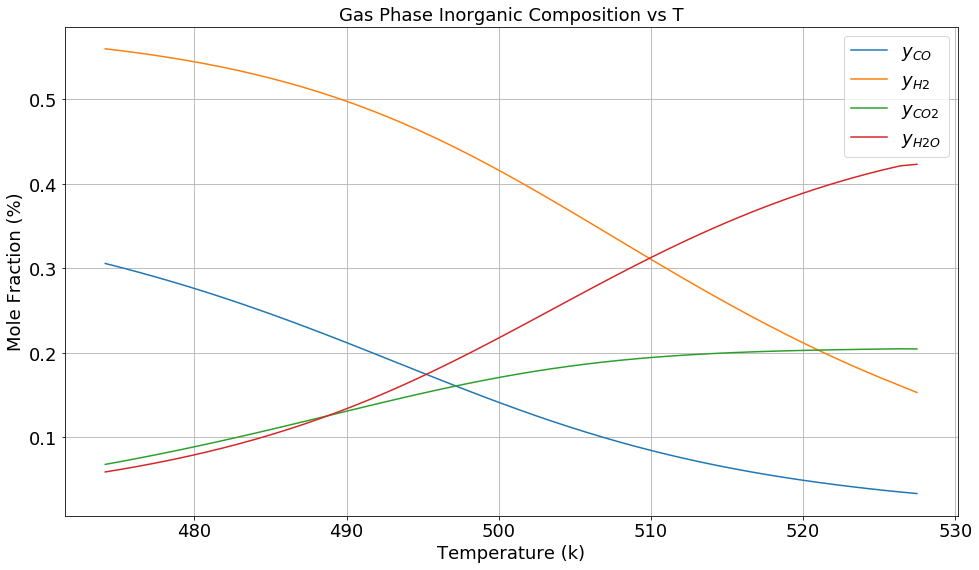

In [38]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

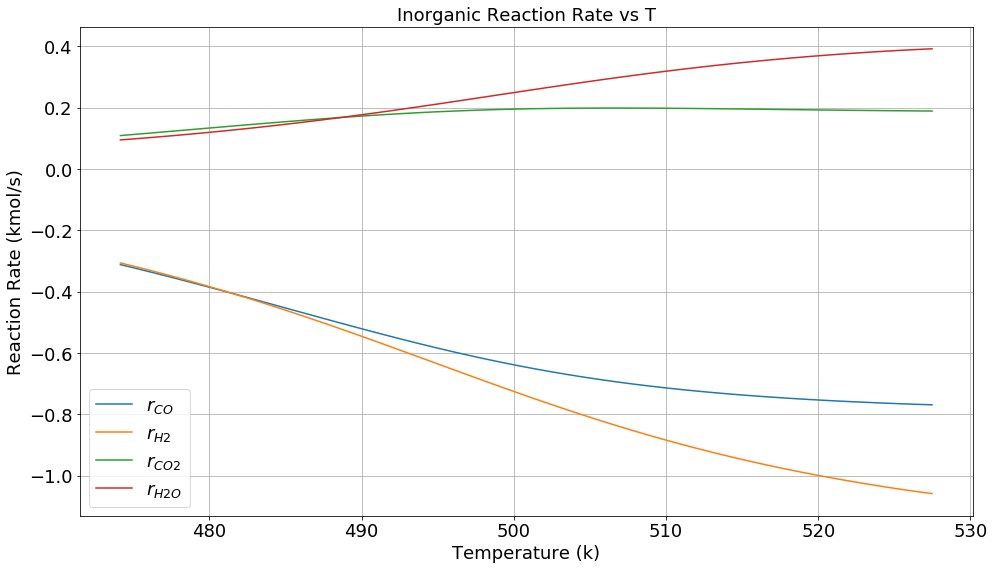

In [39]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

In [40]:
reaction_data = u.trans_product(rf_data['r'])
reaction_scaled = u.trans_product_scaled(rf_data['r'])

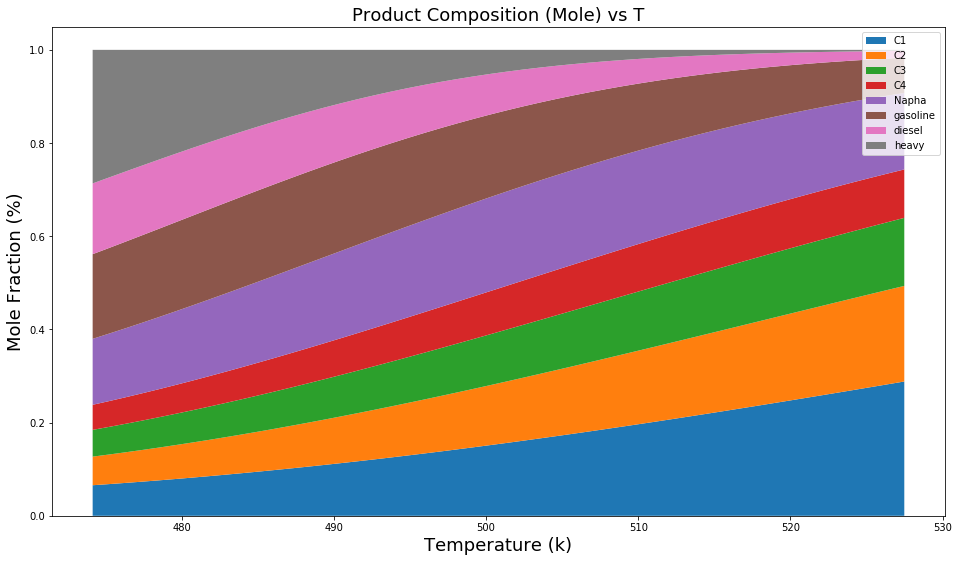

In [41]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_scaled['c1'], reaction_scaled['c2'],reaction_scaled['c3'],reaction_scaled['c4'],\
            reaction_scaled['napha'],reaction_scaled['gasoline'],reaction_scaled['diesel'],reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

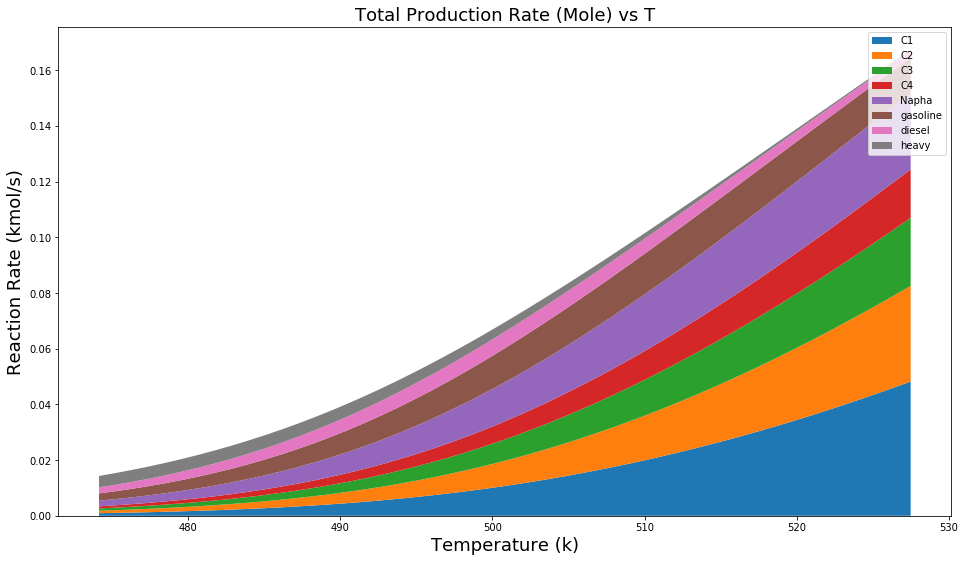

In [42]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [43]:
mass_data = {}
for i in m.COMP_ORG:
    mass_data[i] = np.array(rf_data['r'][i])*u.cal_MW(i)

In [44]:
mass_reaction_data = u.trans_product(mass_data)
mass_reaction_scaled = u.trans_product_scaled(mass_data)

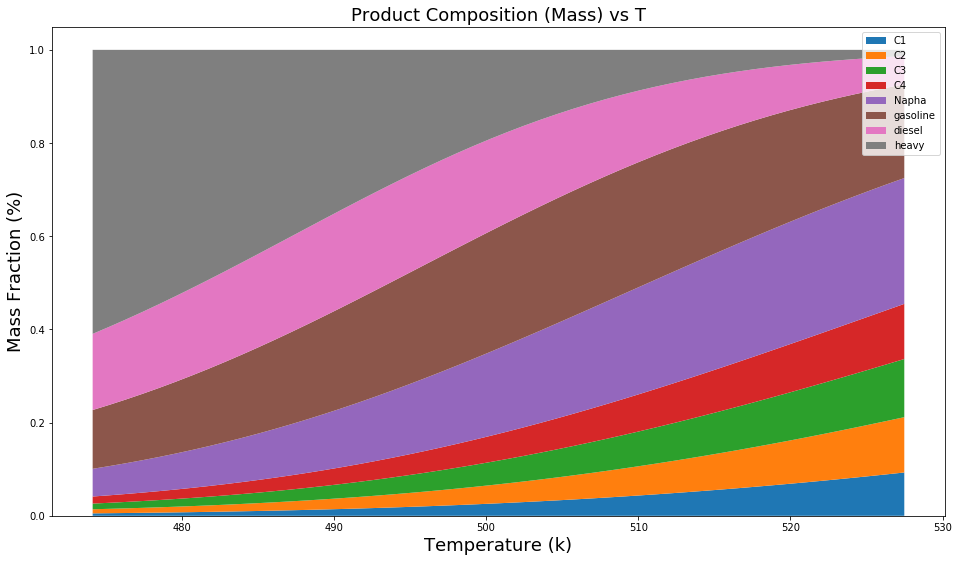

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

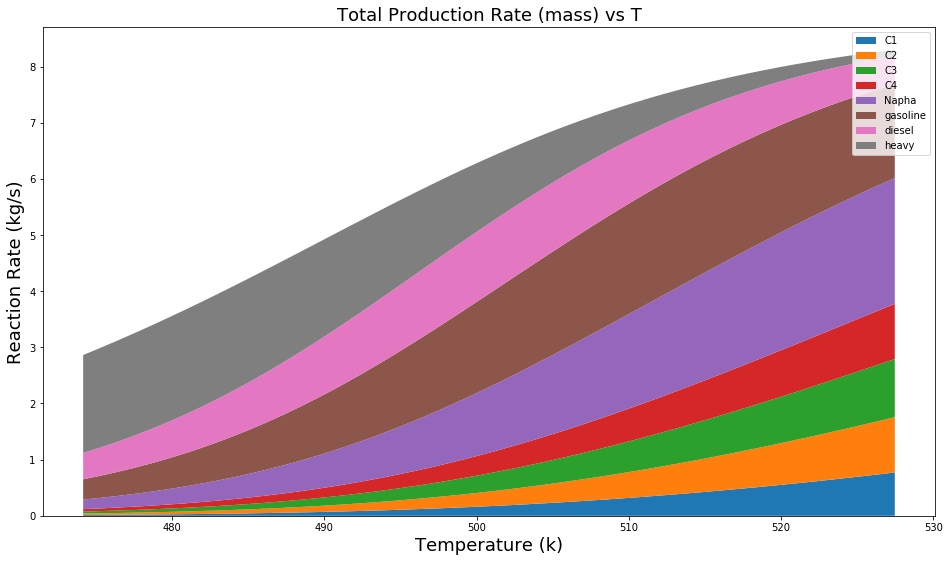

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()